## Load the training dataset

In [1]:
import pandas as pd

df_train = pd.read_csv('./Training_datasets/Tiling_training_v1.csv')

df_train.head()

,sgRNASeq,Seq_Lindel,Seq_Indelphi,Chr,sgRNA.location,Symbol,AA,DLD1_Z-score,NCI.H1299_Z-score,RKO_Z-score,...,Conservation,Helix,Sheet,Phosphorylation,Acetylation,PROVEAN_score,SIFT_score,PROVEAN_STD,SIFT_STD,AA.num
0,TGGTGGATCACAGCATCTTC,GGGTGAAGCTGGGTGGTGGATCACAGCATCTTCTGGAATAGGGCGA...,TGAAGCTGGGTGGTGGATCACAGCATCTTCTGGAATAGGGCGATGG...,6,31745380,VARS,1262,0.923941,1.379081,1.616493,...,0.139737,1,0,0.0,0.0,-3.47,0.139737,5.077772,1.522657,0.447634
1,ATCACAGCATCTTCTGGAAT,AGCTGGGTGGTGGATCACAGCATCTTCTGGAATAGGGCGATGGCCT...,TGGGTGGTGGATCACAGCATCTTCTGGAATAGGGCGATGGCCTCAT...,6,31745386,VARS,1260,1.232309,0.971464,1.365712,...,0.438528,1,0,0.0,0.0,-4.86,0.438528,5.077772,1.522657,0.447634
2,TCACAGCATCTTCTGGAATA,GCTGGGTGGTGGATCACAGCATCTTCTGGAATAGGGCGATGGCCTC...,GGGTGGTGGATCACAGCATCTTCTGGAATAGGGCGATGGCCTCATC...,6,31745387,VARS,1260,1.250667,1.269338,1.804578,...,0.438528,1,0,0.0,0.0,-4.86,0.438528,5.077772,1.522657,0.447634
3,CATCTTCTGGAATAGGGCGA,TGGTGGATCACAGCATCTTCTGGAATAGGGCGATGGCCTCATCCAC...,TGGATCACAGCATCTTCTGGAATAGGGCGATGGCCTCATCCACCTT...,6,31745393,VARS,1258,1.238410,0.893076,1.146280,...,0.717308,1,0,0.0,0.0,-5.60,0.717308,5.077772,1.522657,0.447634
4,AGAGCTCAGGAAGGTGGATG,AACAGACAGAAGCAGAGCTCAGGAAGGTGGATGAGGCCATCGCCCT...,AGACAGAAGCAGAGCTCAGGAAGGTGGATGAGGCCATCGCCCTATT...,6,31745405,VARS,1254,0.729876,1.143917,1.114932,...,1.185435,1,0,0.0,0.0,-6.82,1.185435,5.077772,1.522657,0.447634


## Evaluate feature importance using Gini importance

In [2]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

## Protein features
df_pro = df_train.loc[:,['Essential_Zscore','Domain_pfam','PROVEAN_score','SIFT_score','Helix','Sheet','Phosphorylation','Acetylation']]
## Indel features
df_ind = df_train.loc[:,['Essential_Zscore','FrameShift_IndelPhi','FrameShift_Lindel','FrameShift_FORECasT']]
## sgRNA sequence features
df_seq = df_train.loc[:,['Essential_Zscore','Doench_score','SSC_score','DeepHF_score']]

## Feature importance using Randomforest
rf_p = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                             max_depth=15,max_features='sqrt',random_state=10)
rf_i = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                             max_depth=15,max_features='sqrt',random_state=10)
rf_s = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                             max_depth=15,max_features='sqrt',random_state=10)

rf_p.fit(df_pro.iloc[:,1:],df_pro['Essential_Zscore'])
rf_i.fit(df_ind.iloc[:,1:],df_ind['Essential_Zscore'])
rf_s.fit(df_seq.iloc[:,1:],df_seq['Essential_Zscore'])


feat_pro = list(df_pro.iloc[:,1:].columns);importance_pro = list(rf_p.feature_importances_)
x = sorted([(feat_pro[i],importance_pro[i]) for i in range(7)],key=lambda y:y[1],reverse=True)

feat_ind = list(df_ind.iloc[:,1:].columns);importance_ind = list(rf_i.feature_importances_)
y = sorted([(feat_ind[i],importance_ind[i]) for i in range(3)],key=lambda y:y[1],reverse=True)

feat_seq = list(df_seq.iloc[:,1:].columns);importance_seq = list(rf_s.feature_importances_)
z = sorted([(feat_seq[i],importance_seq[i]) for i in range(3)],key=lambda y:y[1],reverse=True)

print(x) ## Feature importance of protein feature
print(y) ## Feature importance of indel feature
print(z) ## Feature importance of sgRNA seq feature

[('PROVEAN_score', 0.46794499401044065), ('SIFT_score', 0.2590016404172553), ('Domain_pfam', 0.11352823297398718), ('Phosphorylation', 0.0907329136274392), ('Acetylation', 0.02986851365128401), ('Helix', 0.025540096323895266), ('Sheet', 0.013383608995698494)]
[('FrameShift_IndelPhi', 0.3536427352978286), ('FrameShift_FORECasT', 0.3316172453981099), ('FrameShift_Lindel', 0.31474001930406176)]
[('DeepHF_score', 0.5256164852983951), ('Doench_score', 0.26069312636798586), ('SSC_score', 0.21369038833361928)]


## Evaluate feature importance using permutation importance

In [3]:
from rfpimp import *

## Protein features
df_pro = df_train.loc[:,['Essential_Zscore','Domain_pfam','PROVEAN_score','SIFT_score','Helix','Sheet','Phosphorylation','Acetylation']]
## Indel features
df_ind = df_train.loc[:,['Essential_Zscore','FrameShift_IndelPhi','FrameShift_Lindel','FrameShift_FORECasT']]
## sgRNA sequence features
df_seq = df_train.loc[:,['Essential_Zscore','Doench_score','SSC_score','DeepHF_score']]

## Feature importance using Randomforest
rf_p = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                             max_depth=15,max_features='sqrt',random_state=10)
rf_i = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                             max_depth=15,max_features='sqrt',random_state=10)
rf_s = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                             max_depth=15,max_features='sqrt',random_state=10)

imp_pro = permutation_importances(rf_p, df_pro.iloc[:,1:], df_pro['Essential_Zscore'], oob_regression_r2_score)
x = sorted([(imp_pro.index[i],imp_pro['Importance'][i]) for i in range(7)],key=lambda y:y[1],reverse=True)

imp_ind = permutation_importances(rf_i, df_ind.iloc[:,1:], df_ind['Essential_Zscore'], oob_regression_r2_score)
y = sorted([(imp_ind.index[i],imp_ind['Importance'][i]) for i in range(3)],key=lambda y:y[1],reverse=True)

imp_seq = permutation_importances(rf_s, df_seq.iloc[:,1:], df_seq['Essential_Zscore'], oob_regression_r2_score)
z = sorted([(imp_seq.index[i],imp_seq['Importance'][i]) for i in range(3)],key=lambda y:y[1],reverse=True)

print(x) ## Feature importance of protein feature
print(y) ## Feature importance of indel feature
print(z) ## Feature importance of sgRNA seq feature

[('PROVEAN_score', 0.1450390462826444), ('SIFT_score', 0.03811508756303095), ('Domain_pfam', 0.019251302829082606), ('Phosphorylation', 0.016098527087018977), ('Helix', 0.009613692611065039), ('Acetylation', 0.0034991695177720716), ('Sheet', 0.0024409722220020136)]
[('FrameShift_IndelPhi', 0.0336829944596404), ('FrameShift_Lindel', 0.031074177894920396), ('FrameShift_FORECasT', 0.01788384779771468)]
[('DeepHF_score', 0.153789753094419), ('Doench_score', 0.04843967173951369), ('SSC_score', 0.03594238827491403)]


## Evaluate feature importance using drop-columns importance

In [4]:
from sklearn import svm

## Protein features
df_pro = df_train.loc[:,['Essential_Zscore','Domain_pfam','PROVEAN_score','SIFT_score','Helix','Sheet','Phosphorylation','Acetylation']]
## Indel features
df_ind = df_train.loc[:,['Essential_Zscore','FrameShift_IndelPhi','FrameShift_Lindel','FrameShift_FORECasT']]
## sgRNA sequence features
df_seq = df_train.loc[:,['Essential_Zscore','Doench_score','SSC_score','DeepHF_score']]

## Feature importance using Randomforest
sv_p = svm.SVR(kernel='rbf',C=1,gamma=0.01)
sv_i = svm.SVR(kernel='rbf',C=1,gamma=0.01)
sv_s = svm.SVR(kernel='rbf',C=1,gamma=0.01)

imp_pro = dropcol_importances(sv_p, df_pro.iloc[:,1:], df_pro['Essential_Zscore'])
x = sorted([(imp_pro.index[i],imp_pro['Importance'][i]) for i in range(7)],key=lambda y:y[1],reverse=True)

imp_ind = dropcol_importances(sv_i, df_ind.iloc[:,1:], df_ind['Essential_Zscore'])
y = sorted([(imp_ind.index[i],imp_ind['Importance'][i]) for i in range(3)],key=lambda y:y[1],reverse=True)

imp_seq = dropcol_importances(sv_s, df_seq.iloc[:,1:], df_seq['Essential_Zscore'])
z = sorted([(imp_seq.index[i],imp_seq['Importance'][i]) for i in range(3)],key=lambda y:y[1],reverse=True)

print(x) ## Feature importance of protein feature
print(y) ## Feature importance of indel feature
print(z) ## Feature importance of sgRNA seq feature

[('PROVEAN_score', 0.028981044190899086), ('SIFT_score', 0.010761462168531244), ('Domain_pfam', 0.005197073538691588), ('Helix', 0.0029902764840253893), ('Phosphorylation', 0.001425542880529429), ('Sheet', 0.0008370973094122824), ('Acetylation', 1.6225041124307005e-05)]
[('FrameShift_IndelPhi', 0.009065966156951988), ('FrameShift_FORECasT', 0.006484930437717584), ('FrameShift_Lindel', 0.0005306623916517816)]
[('DeepHF_score', 0.06880576411411478), ('SSC_score', 0.011005908977134951), ('Doench_score', 0.01001498668912039)]


## Compare performance of different models using leave-one-gene-out cross validation

In [ ]:
import random
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge
from pandas import DataFrame


def Assembly(df_train,df_test,model1,model2):
    
    n = df_train.shape[0]
    ix_sep = random.sample(range(n),int(n*0.5))
    ix_asm = [i for i in range(n) if i not in ix_sep]
    
    df_sep = df_train.iloc[ix_sep,:]
    df_asm = df_train.iloc[ix_asm,:]
    
    s_seq = df_sep.loc[:,['Essential_Zscore','Doench_score','SSC_score','DeepHF_score']]
    a_seq = df_asm.loc[:,['Essential_Zscore','Doench_score','SSC_score','DeepHF_score']]
    
    s_pro = df_sep.loc[:,['Essential_Zscore','Domain_pfam','PROVEAN_score','SIFT_score',
                           'Helix','Sheet','Phosphorylation','Acetylation']]
    
    a_pro = df_asm.loc[:,['Essential_Zscore','Domain_pfam','PROVEAN_score','SIFT_score',
                           'Helix','Sheet','Phosphorylation','Acetylation']]
    
    s_ind = df_sep.loc[:,['Essential_Zscore','FrameShift_IndelPhi','FrameShift_Lindel']]
    
    a_ind = df_asm.loc[:,['Essential_Zscore','FrameShift_IndelPhi','FrameShift_Lindel']]
    
    
    if model1 == 'SVM':
        svr1 = svm.SVR(kernel='rbf',C=1,gamma=0.01) #RandomForestRegressor()#svm.SVR(kernel='rbf')
        svr2 = svm.SVR(kernel='rbf',C=1,gamma=0.01) #RandomForestRegressor()#svm.SVR(kernel='rbf')
        svr3 = svm.SVR(kernel='rbf',C=1,gamma=0.01) #RandomForestRegressor()#svm.SVR(kernel='rbf')
    
    if model1 == 'RF':
        svr1 = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                                     max_depth=15,max_features='sqrt',random_state=10)
        svr2 = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                                     max_depth=15,max_features='sqrt',random_state=10)
        svr3 = RandomForestRegressor(n_estimators=100, min_samples_split=100,min_samples_leaf=20,
                                     max_depth=15,max_features='sqrt',random_state=10)
    
    sv_seq = svr1.fit(scale(s_seq.iloc[:,1:]),s_seq['Essential_Zscore'])
    sv_pro = svr2.fit(scale(s_pro.iloc[:,1:]),s_pro['Essential_Zscore'])
    sv_ind = svr3.fit(scale(s_ind.iloc[:,1:]),s_ind['Essential_Zscore'])
    
    df_asm['seq_score'] = list(sv_seq.predict(scale(a_seq.iloc[:,1:])))
    df_asm['pro_score'] = list(sv_pro.predict(scale(a_pro.iloc[:,1:])))
    df_asm['ind_score'] = list(sv_ind.predict(scale(a_ind.iloc[:,1:])))
    
    if model2 == 'LR':
        svl1 = LinearRegression()
        svl2 = LinearRegression()
        svl3 = LinearRegression()
        svl4 = LinearRegression()
    
    if model2 == 'RD':
        svl1 = Ridge()
        svl2 = Ridge()
        svl3 = Ridge()
        svl4 = Ridge()
    
    if model2 == 'SVL':
        svl1 = svm.SVR(kernel='linear')
        svl2 = svm.SVR(kernel='linear')
        svl3 = svm.SVR(kernel='linear')
        svl4 = svm.SVR(kernel='linear')
        
    asm1 = svl1.fit(df_asm.loc[:,['seq_score','pro_score','ind_score']],df_asm['Essential_Zscore'])
    asm2 = svl2.fit(df_asm.loc[:,['seq_score','pro_score']],df_asm['Essential_Zscore'])
    asm3 = svl3.fit(df_asm.loc[:,['seq_score','ind_score']],df_asm['Essential_Zscore'])
    asm4 = svl4.fit(df_asm.loc[:,['pro_score','ind_score']],df_asm['Essential_Zscore'])
    
    seq_score = list(sv_seq.predict(scale(df_test.loc[:,['Doench_score','SSC_score','DeepHF_score']])))
    pro_score = list(sv_pro.predict(scale(df_test.loc[:,['Domain_pfam','PROVEAN_score','SIFT_score',
                           'Helix','Sheet','Phosphorylation','Acetylation']])))
    ind_score = list(sv_ind.predict(scale(df_test.loc[:,['FrameShift_IndelPhi','FrameShift_Lindel']])))
    
    df_test['seq_score'] = seq_score
    df_test['pro_score'] = pro_score
    df_test['ind_score'] = ind_score
    
    combined_all = list(asm1.predict(df_test.loc[:,['seq_score','pro_score','ind_score']]))
    combined_seq_pro = list(asm2.predict(df_test.loc[:,['seq_score','pro_score']]))
    combined_seq_ind = list(asm3.predict(df_test.loc[:,['seq_score','ind_score']]))
    combined_pro_ind = list(asm4.predict(df_test.loc[:,['pro_score','ind_score']]))
    
    return seq_score,pro_score,ind_score,combined_seq_ind,combined_seq_pro,combined_pro_ind,combined_all
    

df7 = pd.read_csv('./Training_datasets/Tiling_training_v1.csv')

gene_list = list(set(df7['Symbol']))
kf = KFold(n_splits=46)

for model in [('SVM','LR'),('SVM','RD'),('SVM','SVL'),('RF','SVL'),('RF','LR'),('RF','RD')]:
    model1 = model[0]; model2 = model[1]
    print(model1,model2)
    df_LoF = pd.DataFrame()
    for train_ix, test_ix in kf.split(gene_list):
        df_train = df7[df7['Symbol'] == gene_list[train_ix[0]]]
        df_test = df7[df7['Symbol'] == gene_list[test_ix[0]]]
        for i in train_ix[1:]:
            gene = gene_list[i]
            df_train = pd.concat([df_train,df7[df7['Symbol'] == gene]])
    
        ls1 = []; ls2 = []; ls3 = []; ls4 = []; ls5 = []; ls6 = []; ls7 = []
        for j in range(10):
            s1,s2,s3,s4,s5,s6,s7 = Assembly(df_train,df_test,model1,model2)
            ls1.append(s1); ls2.append(s2); ls3.append(s3); ls4.append(s4)
            ls5.append(s5); ls6.append(s6); ls7.append(s7)
    
        df_test['seq_score'] = list(DataFrame(ls1).T.mean(axis=1))
        df_test['pro_score'] = list(DataFrame(ls2).T.mean(axis=1))
        df_test['ind_score'] = list(DataFrame(ls3).T.mean(axis=1))
        df_test['combined_seq_ind'] = list(DataFrame(ls4).T.mean(axis=1))
        df_test['combined_seq_pro'] = list(DataFrame(ls5).T.mean(axis=1))
        df_test['combined_pro_ind'] = list(DataFrame(ls6).T.mean(axis=1))
        df_test['combined_all'] = list(DataFrame(ls7).T.mean(axis=1))
    
        df_LoF = pd.concat([df_LoF,df_test])

    df_LoF.to_csv('./Training_datasets/Assembly_results_'+model1+'_'+model2+'.csv',index=False)

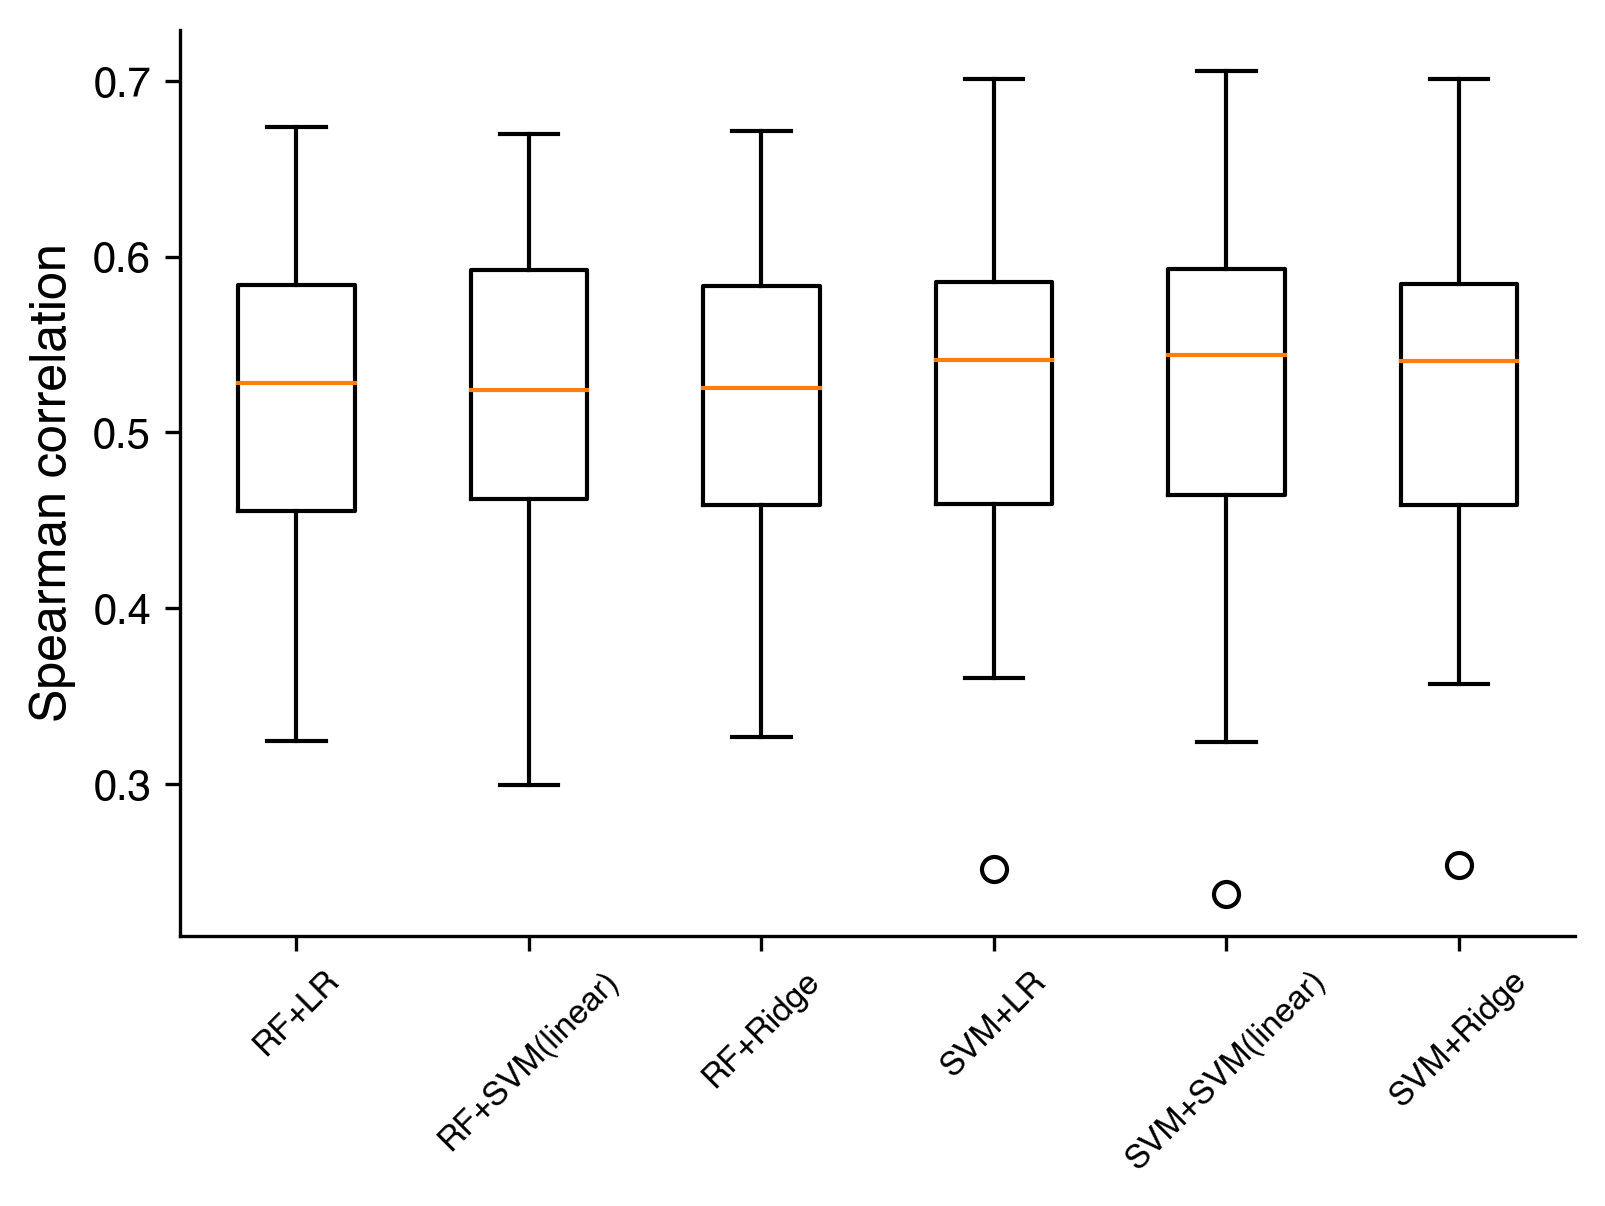

In [6]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt


df_LoF1 = pd.read_csv('./Training_datasets/Assembly_results_RF_LR.csv')
df_LoF2 = pd.read_csv('./Training_datasets/Assembly_results_RF_RD.csv')
df_LoF3 = pd.read_csv('./Training_datasets/Assembly_results_RF_SVL.csv')
df_LoF4 = pd.read_csv('./Training_datasets/Assembly_results_SVM_SVL.csv')
df_LoF5 = pd.read_csv('./Training_datasets/Assembly_results_SVM_LR.csv')
df_LoF6 = pd.read_csv('./Training_datasets/Assembly_results_SVM_RD.csv')

gene_list = list(set(df_train['Symbol']))

rf_all = []; svm_all = []; svl_all = []; lr_all = []; rd_all = []
rf_lr = []; rf_svl = []; rf_rd = []; svm_lr = []; svm_svl = []; svm_rd = []

for gene in gene_list:
    df2 = df_LoF1[df_LoF1['Symbol']==gene]
    df3 = df_LoF2[df_LoF2['Symbol']==gene]
    df4 = df_LoF3[df_LoF3['Symbol']==gene]
    df5 = df_LoF4[df_LoF4['Symbol']==gene]
    df6 = df_LoF5[df_LoF5['Symbol']==gene]
    df7 = df_LoF6[df_LoF6['Symbol']==gene]
    
    rf_lr.append(spearmanr(df2['combined_all'],df2['Essential_Zscore'])[0])
    rf_rd.append(spearmanr(df3['combined_all'],df3['Essential_Zscore'])[0])
    rf_svl.append(spearmanr(df4['combined_all'],df4['Essential_Zscore'])[0])
    svm_lr.append(spearmanr(df6['combined_all'],df6['Essential_Zscore'])[0])
    svm_rd.append(spearmanr(df7['combined_all'],df7['Essential_Zscore'])[0])
    svm_svl.append(spearmanr(df5['combined_all'],df5['Essential_Zscore'])[0])
    

plt.figure(figsize=(6,4),dpi=300)

plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "Helvetica"

plt.boxplot([rf_lr,rf_svl,rf_rd,svm_lr,svm_svl,svm_rd],
            labels=['RF+LR','RF+SVM(linear)','RF+Ridge','SVM+LR','SVM+SVM(linear)','SVM+Ridge'])
plt.ylabel('Spearman correlation',fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Compare the performance of different feature combinations using leave-one-gene-out cross validation

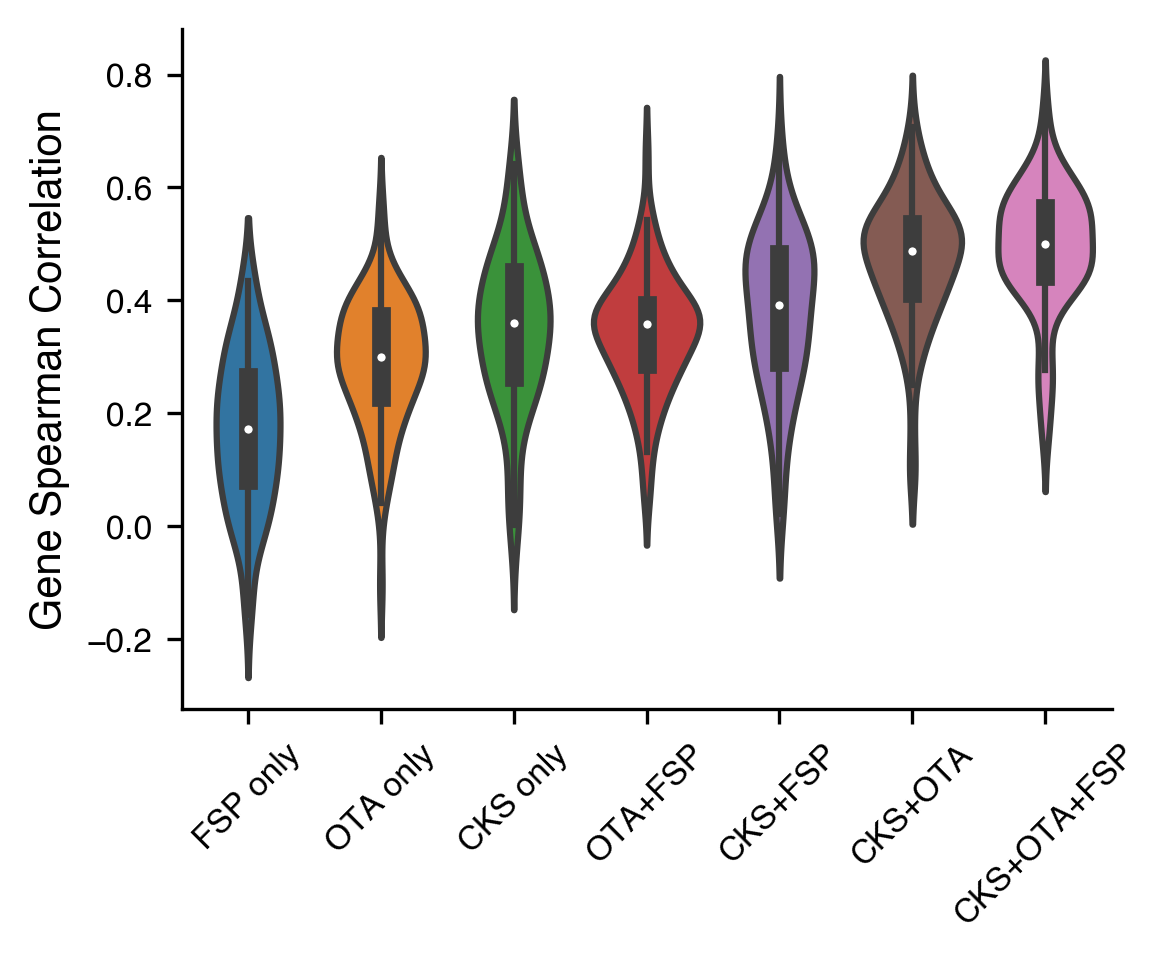

In [8]:
import seaborn as sns
from pandas import DataFrame

df = pd.read_csv('Leave-one-gene-out-results.csv')

ls1 = []; ls2 = []; ls3 = []; ls4 = []; ls5 = []; ls6 = []; ls7 = []
for gene in list(set(df['Symbol'])):
    df_gene = df[df['Symbol']==gene]
    df_gene.index = range(df_gene.shape[0])
    com1_ls = [];com2_ls = [];com3_ls = [];com4_ls = [];com5_ls = [];com6_ls = []
    ls1.append(spearmanr(df_gene['ind_score'],df_gene['Essential_Zscore'])[0])
    ls2.append(spearmanr(df_gene['seq_score'],df_gene['Essential_Zscore'])[0])
    ls3.append(spearmanr(df_gene['pro_score'],df_gene['Essential_Zscore'])[0])
    ls4.append(spearmanr(df_gene['combined_seq_ind'],df_gene['Essential_Zscore'])[0])
    ls5.append(spearmanr(df_gene['combined_pro_ind'],df_gene['Essential_Zscore'])[0])
    ls6.append(spearmanr(df_gene['combined_seq_pro'],df_gene['Essential_Zscore'])[0])
    ls7.append(spearmanr(df_gene['combined_normal'],df_gene['Essential_Zscore'])[0])
        
data = DataFrame([ls1,ls2,ls3,ls4,ls5,ls6,ls7],index=['FSP only','OTA only','CKS only',
                 'OTA+FSP','CKS+FSP','CKS+OTA','CKS+OTA+FSP']).T

plt.figure(figsize=(4,3),dpi=300)
plt.rcParams['font.family'] = 'Helvetica'

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.violinplot(data=data) 
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Gene Spearman Correlation',fontsize=10)
plt.show()